# **Modelado geométrico en tres dimensiones del sistema Tierra-Luna-Sol para la predicción de eclipses solares**


In [52]:
## Importar bibliotecas externas.
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import sympy as smp
import scipy as sp
import csv
import os
from scipy.optimize import curve_fit, root
from scipy.fft import fft, fftfreq
from google.colab import files
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
from IPython.display import HTML

# Posición de los cuerpos celestes
La Primera Ley de Kepler establece que los planetas describen órbitas elípticas con el Sol en uno de sus focos. De manera análoga, la Luna describe una órbita elíptica alrededor de la Tierra, situada en el foco correspondiente.

A continuación, desarrollaremos estrategias para modelar la posición de los cuerpos celestes en función del tiempo. Para ello, resulta fundamental establecer una base temporal para nuestro sistema. Definiremos entonces los fenómenos cíclicos en función de un tiempo común $t$ (adaptable a unidades como segundos, minutos, horas etc), lo que implicará asignar una tasa de cambio y un valor inicial a cada fenómeno.

## 1) Órbita terrestre

Definimos un sistema de referencia $\{\hat{x},\hat{y},\hat{z}\}$, al que llamaremos *Base Solar*, ubicando el origen en el foco correspondiente a la posición del Sol, alineando $\hat{x}$ con la línea que conecta al Sol con la posición del perihelio terrestre y $\hat{y}$ con el semieje menor de la órbita terrestre, de modo que el movimiento de la Tierra resulte antihorario al describirse en coordenadas polares.

Mediante representar la elipse terrestre utilizando coordenadas polares, podemos obtener una expresión para la posición de la Tierra en la Base Solar.


$$
  \vec{r_T}(\theta_T) = \left( \frac{a_T(1-\epsilon^2_T)\cdot cos(\theta_T)}{1-\epsilon_T \cdot cos(\theta_T)}, \frac{a_T(1-\epsilon^2_T)\cdot sin(\theta_T)}{1-\epsilon_T \cdot cos(\theta_T)}, 0 \right)
$$

donde $a_T$ corresponde al *semi-eje mayor* de la órbita elíptica, $\epsilon_T$ es la *excentricidad orbital* y $\theta_T$ es la *anomalía verdadera*, que consiste en el ángulo formado entre el vector posición de la Tierra y el eje $\hat{x}$, medido en sentido antihorario, correspondiente al ángulo polar al emplear la alineación vectorial escogida. Podemos definir el ángulo $\theta_T$ en función de $t$ tal que $\theta_T(t) = \theta_{Ti} + 2\pi t/T_T$, con $T_T$: Periodo de rotación de la Tierra. Definimos el *semi-latus rectum* tal que $l_T=a_T(1-\epsilon^2_T)$.

## 2) Órbita lunar

Para simplificar el modelado de la órbita lunar, vamos a determinar la posición de la Luna con respecto a la Tierra, posteriormente obteniendo la posición respecto al Sol mediante una suma vectorial.

Definimos un sistema de referencia $\{\hat{x}',\hat{y}',\hat{z}'\}$, al que llamaremos *Base Orbital*, ubicando el origen en la posición de la Tierra, alineando $\hat{x}'$ y $\hat{y}'$ con los semiejes mayor y menor de la órbita lunar, respectivamente, de modo que el movimiento de la Luna resulte antihorario al describirse en coordenadas polares. En este sistema, la órbita lunar se encuentra contenida en el plano $x'y'$. Con esto, podemos emplear coordenadas polares para obtener la posición de la Luna en la Base Orbital.

$$
\vec{r}'_L(\theta_L) = \left( \frac{a_L(1-\epsilon^2_L)\cdot \cos(\theta_L)}{1-\epsilon_L \cdot \cos(\theta_L)}, \frac{a_L(1-\epsilon^2_L)\cdot \sin(\theta_L)}{1-\epsilon_L \cdot \cos(\theta_L)}, 0 \right)
$$

definiendo $\theta_L (t) = \theta_{Li} + 2\pi t/T_L$, con $T_L$: Anomalía verdadera de la órbita lunar.

Para poder describir la posición de la Luna en la Base Solar a través de una transformación lineal, consideremos primero las *matrices de rotación pasiva* necesarias para alinear la Base Solar con la inclinación de la Base Orbital en cualquier punto de su evolución. Luego, empleando sus matrices inversas, obtendremos las coordenadas del vector posición de la Luna desde la Tierra en la orientación correcta de la Base Solar.


### a) Inclinación orbital

La órbita luna no se encuentra en el mismo plano que la órbita de la Tierra, cuenta con una inclinación promedio de $5.145^\circ$ con respecto a la *eclíptica* (plano que contiene la órbita terrestre), oscilando en un rango dado por $\pm 0.15^\circ$, con un periodo de $T_i \approx 18.6$ años. Definiendo el ángulo $\alpha(t)=5.145^\circ + 0.15^\circ*sin(\alpha_i + 2\pi t/T_i)$, para obtener la inclinación orbital, realizamos una rotación en torno al eje $\hat{y}$ de la Base Solar.

$$
    S_1^{-1}(\alpha) = \begin{pmatrix} cos(\alpha) & 0 & -sin(\alpha) \\ 0 & 1 & 0 \\ sin(\alpha) & 0 & cos(\alpha)\end{pmatrix}
$$

### b) Precesión nodal

La *precesión nodal* representa una rotación de los *nodos*, puntos en que la órbita lunar interseca al plano de la órbita terrestre, correspondiente a una rotación en torno al eje $\hat{z}$ de la Base Solar.

$$
    S_2^{-1}(\beta) = \begin{pmatrix} cos(-\beta) & -sin(-\beta) & 0 \\ sin(-\beta) & cos(-\beta) & 0 \\ 0 & 0 & 1 \end{pmatrix}
$$

considerando $\beta (t)=\beta_i + 2\pi t/T_n$, donde $T_n$: Periodo de precesión nodal ($T_n\approx 6793 \ \text{días}$). En la ecuación, se emplea $-\beta$ para indicar explícitamente que la precesión nodal ocurre en el sentido opuesto al resto de rotaciones del sistema.

### c) Precesión apsidial

La *precesión apsidial* representa una rotación del segundo foco de la órbita elíptica alrededor del foco que contiene a la Tierra. En nuestro sistema, esto corresponde a una rotación respecto al eje $\hat{z}'$, vector que varía su dirección conforme avanza el tiempo debido a la precisión nodal. Por tanto, sea

$$\hat{z}' = \left( {z}'_{x}, {z}'_{y}, {z}'_{z} \right) = S_2^{-1}(\beta)\cdot S_1^{-1}(\alpha)\cdot \hat{z} = \begin{pmatrix}
-\sin(\alpha)\cos(\beta) \\
\sin(\alpha)\sin(\beta) \\
\cos(\alpha)
\end{pmatrix}$$

podemos emplear la *formula de rotación de Rodriguez* para obtener la matriz de rotación para un eje paralelo a $\hat{z}'$, en función del ángulo $\eta$, definido tal que $\eta(t) = \eta_i + 2\pi t/T_a$, donde $T_a$: Periodo de precesión apsidial ($T_a\approx  3233$ días).

$$
S_3^{-1}(\eta) = \cos(\eta)\cdot \begin{pmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{pmatrix} + [1-\cos(\eta)]\cdot \begin{pmatrix}
({z}'_{x})^2 & {z}'_{x} {z}'_{y} & {z}'_{x} {z}'_{z} \\
{z}'_{y} {z}'_{x} & ({z}'_{y})^2 & {z}'_{y} {z}'_{z} \\
{z}'_{z} {z}'_{x} & {z}'_{z} {z}'_{y} & ({z}'_{z})^2
\end{pmatrix} + \sin(\eta)\cdot \begin{pmatrix}
0 & -z'_z & z'_y \\
z'_z & 0 & -z'_x \\
-z'_y & z'_x & 0
\end{pmatrix}
$$

### d) Expresión resultante

Finalmente, consideramos las inversas de las matrices de rotación previamente definidas para obtener la ecuación general del vector posición de la Luna respecto a la Tierra en la Base Solar. Recordando que para obtener la posición de la Luna respecto al origen, simplemente debemos sumar la expresión anterior al vector posición de la Tierra. Es decir,

$$
\vec{r}_{L}(\theta_L,\alpha,\beta,\eta,\theta_T) = S_1(\alpha)\cdot S_2(\beta)\cdot S_3(\eta)\cdot\left( \frac{a_L(1-\epsilon^2_L)\cdot \cos\big(\theta_L\big)}{1-\epsilon_{L} \cdot \cos(\theta_L)}, \frac{l_{L}\cdot \sin(\theta_L)}{1-\epsilon_{L} \cdot \cos(\theta_L)}, 0 \right) + \vec{r_T}(\theta_T)
$$

donde, con base en las definiciones anteriores, podríamos describir el movimiento lunar únicamente en función del tiempo $t$, de la siguiente manera.

$$
\vec{r}_{L}(t) =
S_1\big[\alpha(t)\big] \cdot
S_2\big[\beta(t)\big] \cdot
S_3\big[\eta(t)\big] \cdot
\left(
\frac{a_L\,\big[1-\epsilon_L^2(t)\big] \cdot \cos\big[\theta_L(t)\big]}
     {1-\epsilon_{L}(t) \cdot \cos\big[\theta_L(t)\big]},
\;
\frac{a_L\,\big[1-\epsilon_L^2(t)\big] \cdot \sin\big[\theta_L(t)\big]}
     {1-\epsilon_{L}(t) \cdot \cos\big[\theta_L(t)\big]},
0
\right)
+ \vec{r_T}\big[\theta_T(t)\big]
$$

In [14]:
## Generación de símbolos necesarios para las posiciones.
a_T, eps_T, thetaT = smp.symbols('a_T, epsilon_T, theta_T') # Tierra
a_L, eps_L, thetaL = smp.symbols('a_L, epsilon_L, theta_L') # Luna
T_i, T_n, T_a = smp.symbols('T_i, T_n, T_a') # Periodos orbitales
alpha, eta, beta = smp.symbols('alpha, eta, beta') # Parámetros orbitales
z_x, z_y, z_z = smp.symbols('z_x, z_y, z_z') # Componentes del vector 'z_BT'
z_BT = smp.Matrix([z_x, z_y, z_z]) # Eje z' de la Base Terrestre
t = smp.symbols('t', real = True) # Tiempo

In [15]:
## Obtener la posición de la Tierra en la Base Solar.

# Posición de la Tierra en la Base Solar.
mrT = a_T*(1-eps_T**2)/(1-eps_T*smp.cos(thetaT)) # Magnitud
rT = mrT*smp.Matrix([smp.cos(thetaT), smp.sin(thetaT), 0]) # Vector
rT_f = smp.lambdify(thetaT, rT, "numpy") # Función rT(thetaT)

# Visualización.
rT

Matrix([
[a_T*(1 - epsilon_T**2)*cos(theta_T)/(-epsilon_T*cos(theta_T) + 1)],
[a_T*(1 - epsilon_T**2)*sin(theta_T)/(-epsilon_T*cos(theta_T) + 1)],
[                                                                0]])

In [16]:
# Posición de la Luna en la Base Orbital.
mrL = a_L*(1-eps_L**2)/(1-eps_L*smp.cos(thetaL)) # Magnitud
rL_BO = mrL*smp.Matrix([smp.cos(thetaL), smp.sin(thetaL), 0]) # Vector
rL_BO_f = smp.lambdify((thetaL, eps_L), rL_BO, "numpy") # Función rL_BO(thetaL, eps_L)

# Visualización.
rL_BO

Matrix([
[a_L*(1 - epsilon_L**2)*cos(theta_L)/(-epsilon_L*cos(theta_L) + 1)],
[a_L*(1 - epsilon_L**2)*sin(theta_L)/(-epsilon_L*cos(theta_L) + 1)],
[                                                                0]])

In [17]:
# Inclinación orbital de la Luna.
S_1_inv = smp.Matrix([[smp.cos(alpha), 0, -smp.sin(alpha)], [0, 1, 0], [smp.sin(alpha), 0, smp.cos(alpha)]])

# Visualización.
S_1_inv

Matrix([
[cos(alpha), 0, -sin(alpha)],
[         0, 1,           0],
[sin(alpha), 0,  cos(alpha)]])

In [18]:
# Precesión nodal.
S_2_inv = smp.Matrix([[smp.cos(-beta), -smp.sin(-beta), 0], [smp.sin(-beta), smp.cos(-beta), 0], [0, 0, 1]])

# Visualización.
S_2_inv

Matrix([
[ cos(beta), sin(beta), 0],
[-sin(beta), cos(beta), 0],
[         0,         0, 1]])

In [19]:
# Precesión apsidial.
z_BO = S_2_inv*S_1_inv*smp.Matrix([0, 0, 1])
S_3_inv = smp.cos(eta)*smp.eye(3) + (1-smp.cos(eta))*(z_BO*z_BO.T) + smp.sin(eta)*smp.Matrix([[0, -z_BO[2], z_BO[1]], [z_BO[2], 0, -z_BO[0]], [-z_BO[1], z_BO[0], 0]])

# Visualización.
S_3_inv

Matrix([
[                           (1 - cos(eta))*sin(alpha)**2*cos(beta)**2 + cos(eta),        -(1 - cos(eta))*sin(alpha)**2*sin(beta)*cos(beta) - sin(eta)*cos(alpha), -(1 - cos(eta))*sin(alpha)*cos(alpha)*cos(beta) + sin(alpha)*sin(beta)*sin(eta)],
[        -(1 - cos(eta))*sin(alpha)**2*sin(beta)*cos(beta) + sin(eta)*cos(alpha),                           (1 - cos(eta))*sin(alpha)**2*sin(beta)**2 + cos(eta),  (1 - cos(eta))*sin(alpha)*sin(beta)*cos(alpha) + sin(alpha)*sin(eta)*cos(beta)],
[-(1 - cos(eta))*sin(alpha)*cos(alpha)*cos(beta) - sin(alpha)*sin(beta)*sin(eta), (1 - cos(eta))*sin(alpha)*sin(beta)*cos(alpha) - sin(alpha)*sin(eta)*cos(beta),                                         (1 - cos(eta))*cos(alpha)**2 + cos(eta)]])

In [20]:
# Invertir las matrices de rotación.
S_1 = S_1_inv.inv()
S_2 = S_2_inv.inv()
S_3 = S_3_inv.inv()

In [21]:
# Obtener la posición de la Luna, respecto al Sol, en la Base Solar.
rL_T = S_1*S_2*S_3*rL_BO
rL = rL_T + rT

In [22]:
rL

Matrix([
[a_L*(1 - epsilon_L**2)*((-sin(alpha)**2/cos(alpha) + 1/cos(alpha))*(-sin(beta)**2/cos(beta) + 1/cos(beta))*(sin(alpha)**2*sin(beta)**2*cos(eta)**2 - sin(alpha)**2*sin(beta)**2*cos(eta) - sin(alpha)**2*sin(eta)**2*cos(beta)**2 + cos(alpha)**2*cos(eta)**2 - cos(alpha)**2*cos(eta) - cos(eta)**2)/(sin(alpha)**4*sin(beta)**4*sin(eta)**2*cos(eta) - sin(alpha)**4*sin(beta)**4*sin(eta)**2 + 2*sin(alpha)**4*sin(beta)**2*sin(eta)**2*cos(beta)**2*cos(eta) - 2*sin(alpha)**4*sin(beta)**2*sin(eta)**2*cos(beta)**2 + sin(alpha)**4*sin(eta)**2*cos(beta)**4*cos(eta) - sin(alpha)**4*sin(eta)**2*cos(beta)**4 + 2*sin(alpha)**2*sin(beta)**2*sin(eta)**2*cos(alpha)**2*cos(eta) - 2*sin(alpha)**2*sin(beta)**2*sin(eta)**2*cos(alpha)**2 - sin(alpha)**2*sin(beta)**2*sin(eta)**2*cos(eta) + sin(alpha)**2*sin(beta)**2*cos(eta)**3 - sin(alpha)**2*sin(beta)**2*cos(eta)**2 + 2*sin(alpha)**2*sin(eta)**2*cos(alpha)**2*cos(beta)**2*cos(eta) - 2*sin(alpha)**2*sin(eta)**2*cos(alpha)**2*cos(beta)**2 - sin(alpha)**2*

### f) Excentricidad de la órbita lunar

Determinar una ecuación acertada para la excentricidad de la órbita lunar $\epsilon_L$ puede ser una tarea sumamente compleja. Hasta el momento, los movimientos que hemos descrito presentan una periodicidad conocida que facilitan su modelado. Sin embargo, la magnitud de factores que influyen en la excentricidad lunar se salen completamente de la escala analítica con la que estamos trabajando, presentando variaciones sumamente irregulares desde nuestra perspectiva.

Una solución práctica sería emplear la excentricidad promedio como valor constante, sin embargo, reduciría su exactitud. Por lo tanto, una alternativa corresponde a la obtención de datos reales sobre el valor de excentricidad lunar medido en función del tiempo, para determinar una ecuación aproximada mediante un *ajuste de Fourier con $N$ términos*, tal que

$$
\epsilon_L(t) \approx a_0 + \sum_{n=1}^N \big[a_n cos(nt) + b_n sin(nt)\big]
$$

Nótese que, tal como se indicó anteriormente, la ecuación para determinar la posición de la Luna en la Base Orbital $\vec{r}'_L$ ahora dependerá también de la excentricidad lunar $\epsilon_L(t)$, que se establece como función de $t$.

Una vez obtenida una gráfica de excentricidad lunar obtenida a través de medios oficiales, podemos emplear técnicas de análisis gráfico para generar los arreglos de datos correspondientes, almacenados en el archivo "DatosE.csv" que el código solicitará al usuario ingresar, los cuales serán usados para realizar un ajuste de Fourier respectivo mediante implementación de bibliotecas.

Saving DatosE.csv to DatosE.csv


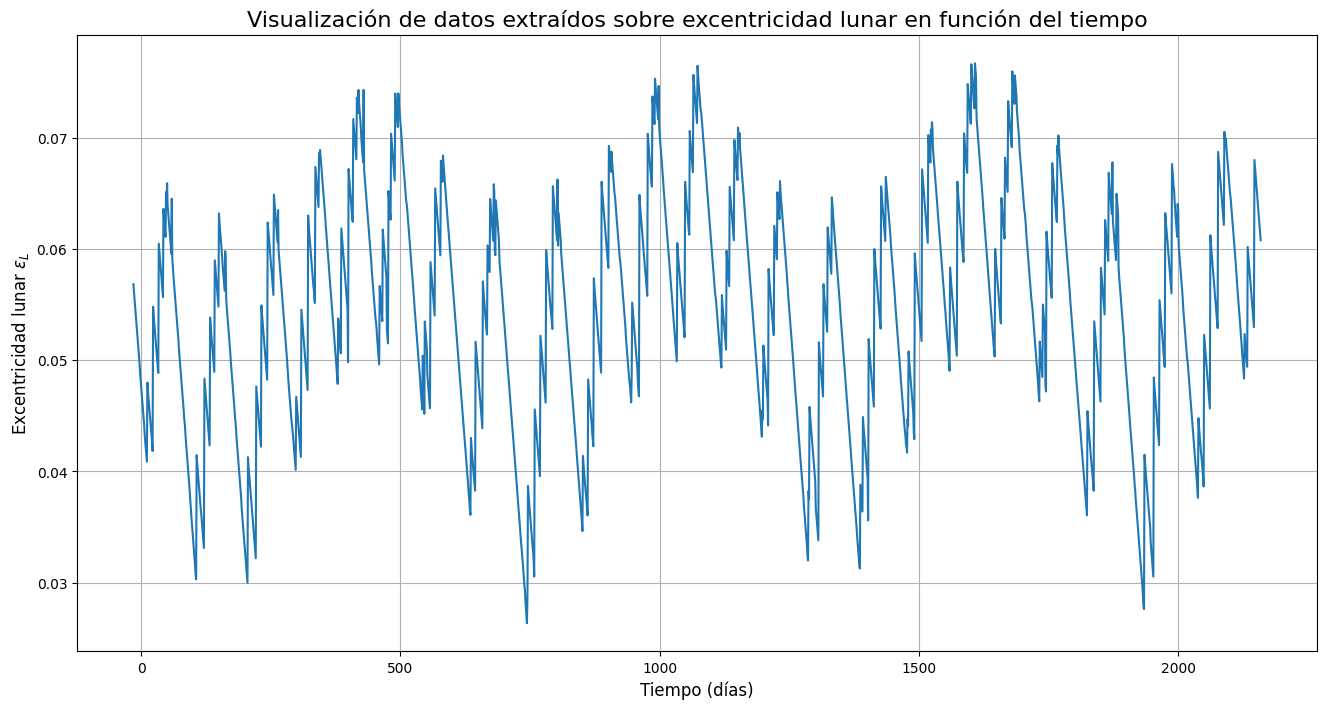

In [23]:
## Extraer datos del archivo "DatosE.csv"

# Detectar la existencia de 'DatosE.csv' en el entorno.
if not os.path.exists('DatosE.csv'):
  files.upload() # Subir el archivo 'DatosE.csv' manualmente.
# Seleccionar el archivo.
file_path = 'DatosE.csv'
# Inicializar la matriz para almacenar los datos.
data_matrix = []
# Leer las primeras 2175 filas (número de datos extraidos).
with open(file_path, mode='r', encoding='utf-8') as file:
    reader = csv.reader(file)
    for i, row in enumerate(reader):
        if i >= 2175:  # Iterar hasta las 2175 filas
            break
        # Primera columna: eliminar '\t0' y convertir a número.
        col1 = float(row[0].replace('\t0', '').strip())
        # Segunda columna: reemplazar ',' con '.' y convertir a número.
        col2 = float(row[1].replace(',', '.').strip()) / 1e17
        # Agregar datos corregidos a la matriz.
        data_matrix.append([col1, col2])
# Convertir la matriz con los datos en un arreglo de NumPy.
data_matrix = np.array(data_matrix)

# Generación de una gráfica para la visualización de los datos extraídos.
plt.figure(figsize=(16, 8))
plt.plot(data_matrix[:, 0], data_matrix[:, 1])
plt.xlabel('Tiempo (días)', fontsize=12)
plt.ylabel(r'Excentricidad lunar $\epsilon_L$', fontsize=12)
plt.title('Visualización de datos extraídos sobre excentricidad lunar en función del tiempo', fontsize=16)
plt.grid(True)
plt.show()

/tmp/ipython-input-3127912541.py:32: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(fourier_model, x_data, y_data, p0=initial_guess)


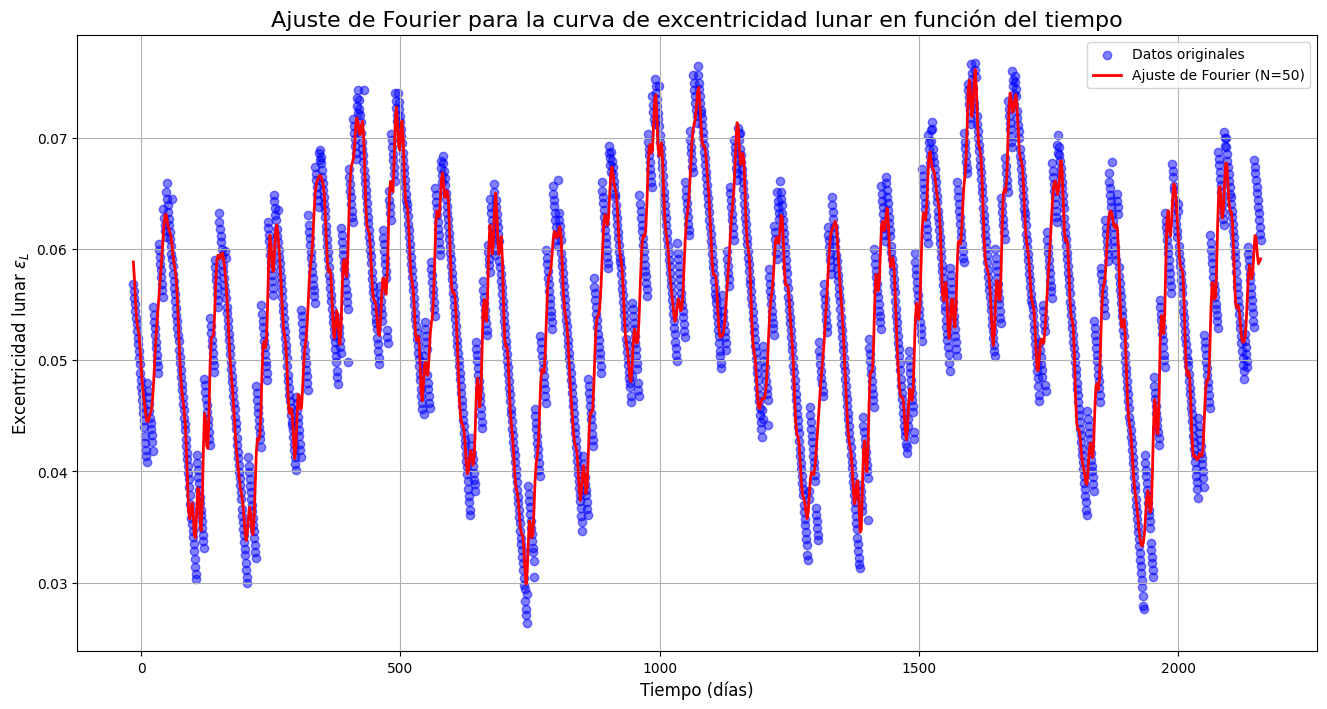

In [24]:
## Ajuste de Fourier para N parámetros.

# Número de términos en el modelo de Fourier.
N = 50

# Separación de datos.
x_data = data_matrix[:, 0]
y_data = data_matrix[:, 1]
# Transformada de Fourier para identificar las frecuencias armónicas asociadas.
n = len(x_data)
dt = (x_data[-1] - x_data[0]) / (n - 1)  # Separación uniforme.
frequencies = fftfreq(n, dt)
fft_values = fft(y_data)
positive_frequencies = frequencies[:n // 2]
amplitudes = np.abs(fft_values[:n // 2])
# Ordenar las frecuencias dominantes por amplitud.
sorted_indices = np.argsort(amplitudes)[::-1]
dominant_frequencies = positive_frequencies[sorted_indices]
# Construir modelo de Fourier con N términos.
def fourier_model(x, *params):
    a0 = params[0]
    result = a0
    for i in range(1, N + 1):
        a = params[2 * i - 1]
        b = params[2 * i]
        f = dominant_frequencies[i - 1]
        result += a * np.sin(2 * np.pi * f * x) + b * np.cos(2 * np.pi * f * x)
    return result
# Valores iniciales, para optimizar la convergencia.
initial_guess = [np.mean(y_data)] + [0.1, 0.1] * N
# Ajustar modelo.
popt, _ = curve_fit(fourier_model, x_data, y_data, p0=initial_guess)
# Generar valores ajustados.
x_fit = np.linspace(x_data.min(), x_data.max(), 1000)
y_fit = fourier_model(x_fit, *popt)

# Generación de una gráfica para la visualización del ajuste realizado.
plt.figure(figsize=(16, 8))
plt.scatter(x_data, y_data, color='blue', alpha=0.5, label='Datos originales')
plt.plot(x_fit, y_fit, color='red', linewidth=2, label=f'Ajuste de Fourier (N={N})')
plt.title('Ajuste de Fourier para la curva de excentricidad lunar en función del tiempo', fontsize=16)
plt.xlabel('Tiempo (días)', fontsize=12)
plt.ylabel(r'Excentricidad lunar $\epsilon_L$', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


In [25]:
# Asociar la ecuación del modelo ajustado con la variable 'eps_Fourier'.
eps_Fourier = popt[0] # Término constante 'a0'.
for i in range(N):
    a = popt[2 * i + 1] # Coeficiente de 'sin()'
    b = popt[2 * i + 2] # Coeficiente de 'cos()'
    f = dominant_frequencies[i] # Frecuencia dominante asociada.
    eps_Fourier += a*smp.sin(2*smp.pi*f*t) + b*smp.cos(2*smp.pi*f*t) # Ecuación del modelo.
eps_Fourier_f = smp.lambdify(t, eps_Fourier, "numpy") # Función eps_L(t)

print("Ecuación del modelo ajustado:")
eps_Fourier

Ecuación del modelo ajustado:


-0.000792776525913686*sin(0.000919540229885057*pi*t) + 0.000268546557568073*sin(0.00183908045977011*pi*t) + 0.00116027783324379*sin(0.00275862068965517*pi*t) - 0.00351264693116353*sin(0.00367816091954023*pi*t) - 0.00113069896717467*sin(0.00459770114942529*pi*t) - 0.00047594386453307*sin(0.00551724137931034*pi*t) - 0.000542159520943026*sin(0.00827586206896552*pi*t) + 7.66802678502778e-5*sin(0.0110344827586207*pi*t) - 0.000127477953746659*sin(0.0119540229885057*pi*t) + 0.000292219896499827*sin(0.0128735632183908*pi*t) - 0.000587190418477322*sin(0.0137931034482759*pi*t) - 0.00129114422824686*sin(0.0147126436781609*pi*t) + 0.00137000322889432*sin(0.015632183908046*pi*t) + 0.000129445838472431*sin(0.016551724137931*pi*t) + 0.00123777992981565*sin(0.0174712643678161*pi*t) + 0.00528401658605134*sin(0.0183908045977011*pi*t) - 0.000738835569284754*sin(0.0193103448275862*pi*t) + 0.00043084909094437*sin(0.0202298850574713*pi*t) + 0.000781664847320479*sin(0.0211494252873563*pi*t) - 0.0065013234027

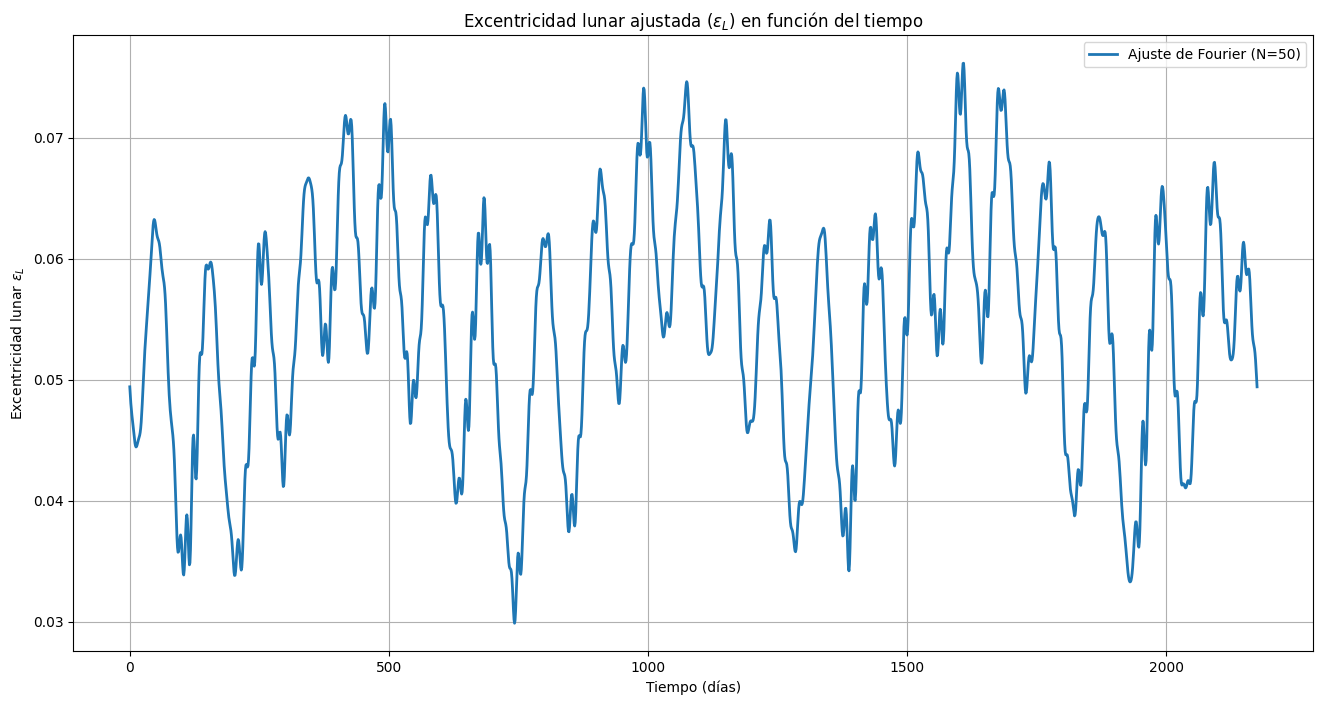

In [26]:
## Graficación de la curva de ajuste obtenida para visualización del resultado.

# Convertir 'eps_L' (simbólica) en una función numérica.
eps_L_f = smp.lambdify(t, eps_Fourier, "numpy")
t_vals = np.linspace(0, 2175, 2175)
plt.figure(figsize=(16, 8))
plt.plot(t_vals, eps_L_f(t_vals), linewidth=2, label=f'Ajuste de Fourier (N={N})' )
plt.title("Excentricidad lunar ajustada ($\\epsilon_L$) en función del tiempo")
plt.xlabel("Tiempo (días)")
plt.ylabel(r"Excentricidad lunar $\epsilon_L$")
plt.grid(True)
plt.legend()
plt.show()

## 3) Valores numéricos en función del tiempo

In [27]:
# Valores numéricos de los periodos orbitales (en días).
T_T = 365.256363004 # Órbita terrestre
T_i = 18.6*365.25 # Inclinación orbital
T_n = 6793 # Precesión nodal
T_a = 3233 # Precesión apsidial
T_L = 29.53058885 # Órbita lunar

# Establecer valores iniciales para los ángulos.
# Nota: Se emplean números pseudoaleatorios.
thetaT0 = np.random.uniform(0, 2*np.pi)
alpha0 = np.random.uniform(0, 2*np.pi)
beta0 = np.random.uniform(0, 2*np.pi)
eta0 = np.random.uniform(0, 2*np.pi)
thetaL0 = np.random.uniform(0, 2*np.pi)

# Parametrizar los ángulos en función de 't'.
thetaT_t = thetaT0 + 2*smp.pi*t/T_T
alpha_t = 5.145*smp.pi/180 + (0.15*smp.pi/180)*smp.sin(alpha0 + 2*smp.pi*t/T_i)
beta_t = beta0 + 2*smp.pi*t/T_n
eta_t = eta0 + 2*smp.pi*t/T_a
thetaL_t = thetaL0 + 2*smp.pi*t/T_L

# Establecer la posición lunar en función de 't' mediante reemplazar parámetros.
rL_T_t = rL_T.subs({
    thetaT: thetaT_t,
    alpha: alpha_t,
    beta: beta_t,
    eta: eta_t,
    thetaL: thetaL_t,
    eps_L: eps_Fourier
})

# Definir la posición lunar respecto a la Tierra como función, i.e. rL(a_L, t).
rL_T_t_f = smp.lambdify((a_L, t), rL_T_t, "numpy")

## Superficie de la Tierra

La elección de la geometría para modelar la superficie de la Tierra dependerá del nivel de detalle que se desee obtener. Por ejemplo, si nuestro objetivo fuera únicamente visualizar la trayectoria de la Luna según la metodología previamente descrita, bastaría con representar ambos cuerpos celestes como esferas, una aproximación suficiente para reflejar la escala de nuestro modelo.

In [50]:
## Visualización de la trayectoria lunar.

# R_T: Radio de la Tierra, R_L: Radio de la Luna, a_L: Semieje mayor de la órbita lunar.
# t_f: Duración de la animación en segundos, D: Días reales por segundo de animación.
# fps: Frames por segundo, save_file: Guardar la animación (true).
def orbita_lunar_dias(R_T=2.5, R_L=1.0, a_L=6.0, t_f=3.0, D=10.0, fps=30.0, save_file=True):
    # Generar la esfera terrestre mediante coordenadas esféricas.
    phi = np.linspace(0, 2*np.pi, 100) # Ángulo azimutal
    theta = np.linspace(0, np.pi, 100) # Ángulo polar
    # Cambio de variable a coordenadas cartesianas.
    x_T = R_T*np.outer(np.cos(phi), np.sin(theta))
    y_T = R_T*np.outer(np.sin(phi), np.sin(theta))
    z_T = R_T*np.outer(np.ones_like(phi), np.cos(theta))

    # Número de frames para 't_f' segundos.
    frames = int(t_f*fps)
    # Arreglo temporal en días.
    t_val = np.linspace(0, t_f*D, frames)

    # Crear figura en 3D.
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    # Asignar una esfera azul a la superficie terrestre.
    ax.plot_surface(x_T, y_T, z_T, color='blue', alpha=0.5, shade=True)

    # Calcular posiciones de la Luna para todos los frames.
    rL_vals = np.array([np.squeeze(rL_T_t_f(a_L, t)) for t in t_val])
    # Representar la Luna con un punto inicial.
    punto_luna, = ax.plot([rL_vals[0,0]], [rL_vals[0,1]], [rL_vals[0,2]], 'o', color='black', markersize=10)
    # Inicializar la trayectoria dinámica de la Luna.
    trayectoria, = ax.plot([rL_vals[0,0]], [rL_vals[0,1]], [rL_vals[0,2]], color='black', lw=1)

    # Inicializar el texto del temporizador.
    tiempo_texto = ax.text2D(0.05, 0.95, f"Días: {t_val[0]:.1f}", transform=ax.transAxes, color='black')

    # Límites del gráfico.
    rango_max = a_L + R_L
    ax.set_xlim(-rango_max, rango_max)
    ax.set_ylim(-rango_max, rango_max)
    ax.set_zlim(-rango_max, rango_max)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Órbita lunar alrededor de la Tierra', color='black')
    ax.grid(True, color='gray', linestyle='-', linewidth=1)

    # Función de actualización de la animación.
    def update(frame):
        punto_luna.set_data([rL_vals[frame,0]], [rL_vals[frame,1]])
        punto_luna.set_3d_properties([rL_vals[frame,2]])
        trayectoria.set_data(rL_vals[:frame+1,0], rL_vals[:frame+1,1])
        trayectoria.set_3d_properties(rL_vals[:frame+1,2])
        tiempo_texto.set_text(f"Días: {t_val[frame]:.1f}")
        return punto_luna, trayectoria, tiempo_texto

    # Crear animación.
    ani = FuncAnimation(fig, update, frames=frames, blit=True)

    # Guardar el archivo.
    if save_file:
        writer = FFMpegWriter(fps=fps) # Para video MP4
        ani.save("orbita_lunar.mp4", writer=writer)
        files.download("orbita_lunar.mp4") # Descargar desde Colab

    # Mostrar animación en el Notebook.
    plt.close(fig)  # Evita la figura estática
    return HTML(ani.to_jshtml())  # Animación interactiva en Colab

# Ejecutar la función.
orbita_lunar_dias()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

En cambio, si quisiéramos detectar intersecciones entre el cono de sombra y la superficie terrestre con la precisión necesaria para predecir los puntos del mapa desde los cuales se observará un eclipse, sería mejor optar por un modelo más detallado.

Veremos cómo representar la forma de la Tierra a partir del modelo desarrollado por F. Javier Gil Chica en su libro _Teoría de Eclipses, Ocultaciones y Tránsitos_ (1996), empleando las ecuaciones que propone para describir las coordenadas $x$, $y$, $z$ de la superficie terrestre mediante una versión modificada del sistema de coordenadas polares.

Este modelo emplea un cambio variable de la forma

$$x=\rho\cdot \cos(\phi'), \ y=\rho\cdot \sin(\phi'), \ \rho(\phi) = \frac{a\cdot (1-2e^2sin^2\phi + e^4 sin^2\phi)}{\sqrt{1-e^2sin^2\phi}}$$

donde $\phi'$ representa la *latitud geocéntrica* y $\rho=\rho(\phi)$ representa el *radio efectivo* en función de la *latitud geográfica* $\phi$. Aquí, $e$ es la _excentricidad de la elipse meridiana_, definida como

$$
e = 1 - (1-c)^2
$$

siendo $c$ el achatamiento terrestre dado por $c=1-b/a$, con $a=6378\ km$ y $b=6357\ km$ correspondientes al _radio ecuatorial_ y al _radio polar_, respectivamente. Este procedimiento involucra, por tanto, dos tipos distintos de latitud. Dado un valor de $\phi'$, el valor correspondiente de $\phi$ se obtiene calculando las raíces de la ecuación

$$
f(\phi, \phi') = \phi - c_1\cdot sin(2\phi) + c_2\cdot sin(4\phi) - \phi' = 0
$$

donde $c_1 = 6.9566\pi/648000$ y $c_2 = 1.17\pi/648000$ son constantes de corrección determinadas empíricamente. Todo lo anterior, nos permitirá graficar una sección meridiana (un corte de la Tierra pasando por su eje de rotación) de la superficie terrestre, semejante a la forma de una elipse.

**Nota:** Al trabajar con mapas de la superficie terrestre en un plano cartesiano, es habitual utilizar coordenadas geográficas, latitud y longitud, para ubicar un punto. En este contexto, por latitud se entiende la latitud geográfica $\phi$.

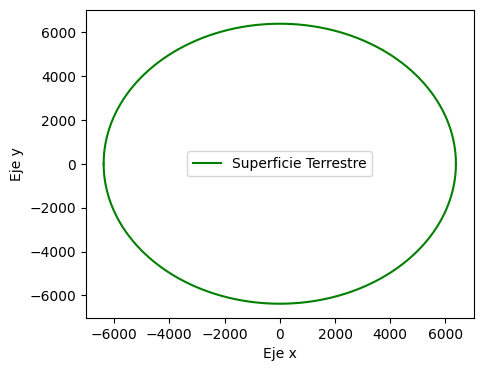

In [29]:
## Graficación de sección meridiana de la Tierra con el "modelo de Chica".

# Constantes de corrección.
c1_n = 6.9566*np.pi/648000
c2_n = 1.17*np.pi/648000
# Constantes geométricas.
a_n = 6378.0 # Radio ecuatorial
b_n = 6357.0 # Radio polar
c_n = 1 - b_n/a_n # Achatamiento terrestre
e_n = 1 - (1-c_n)**2 # Excentricidad de la elipse meridiana

# Arreglo con los valores de "phi_prime".
phi_prime_n = np.arange(0, np.pi, 0.001, dtype=float)

# Función para relacionar las latitudes.
def lat_f(phi, phi_prime):
  return phi - c1_n*np.sin(2*phi) + c2_n*np.sin(4*phi) - phi_prime # = 0

# Almacenar los valores de "phi".
phi_n = np.zeros(len(phi_prime_n))
for i in range(len(phi_prime_n)):
  phi_n[i] = root(lat_f, x0 = phi_prime_n[i], args = (phi_prime_n[i])).x[0]

# Generar los valores de radio efectivo.
rho_n = a_n*(1-2*(e_n)**(2)*np.sin(phi_n)**2 + (e_n)**(4)*(np.sin(phi_n))**2)/(np.sqrt(1-(e_n)**(2)*(np.sin(phi_n)**2)))
# Arreglos de datos para "XY" y "Z".
x_n = rho_n*np.cos(phi_prime_n)
y_n = rho_n*np.sin(phi_prime_n)

# Graficación.
fig, ax = plt.subplots(1,1, figsize = (5,4))
ax.plot(x_n, y_n, color = 'g', label="Superficie Terrestre")
ax.plot(x_n,-y_n, color = 'g')
ax.set_xlabel("Eje x")
ax.set_ylabel("Eje y")
ax.legend()

En esta metodología, el radio efectivo varía únicamente en función de la latitud; por lo tanto, es posible extrapolar fácilmente este modelo a una superficie tridimensional mediante la generación de un sólido de revolución. A continuación, proponemos una serie de modificaciones al _modelo de Chica_ que facilitan la simulación de los movimientos periódicos de la Tierra al ajustarse al estilo de estrategias empleadas hasta ahora.

Definimos un sistema de referencia $\{\hat{x}'', \hat{y}'', \hat{z}''\}$, al que llamaremos *Base Terrestre*, con origen en el centro de la Tierra y alineando el eje $\hat{z}''$ con el eje de rotación de la Tierra (correspondiente al _eje y_ en el modelo original). Esto permite generar círculos simétricos al intersecar la superficie terrestre con planos paralelos al plano $x''y''$. En esta notación, al punto de la superficie que se conecta con el centro mediante una línea paralela a $\hat{x}''$ lo denominamos "_punto 0.0_", indicando que corresponderá a longitud $0.0^\circ$ y latitud $0.0^\circ$ en coordenadas geográficas. Este punto será de gran utilidad más adelante, cuando deseemos emplear una proyección cartográfica, entendida como cualquier transformación que establece una relación ordenada entre los puntos de la superficie terrestre y un plano.

Para generar una superficie tridimensional mediante nuestro _modelo de Chica modificado_, podemos emplear la misma definición de radio efectivo, variando únicamente su relación con las coordenadas cartesianas, de manera análoga a lo que ocurre en coordenadas esféricas. Así, los puntos de la superficie en la Base Terrestre quedan dados por

$$
x''=\rho\cdot \cos(\phi')\cos(\gamma), \ y''=\rho\cdot \cos(\phi')\sin(\gamma), \ z''=\rho\cdot \sin(\phi')
$$

donde $\gamma$ es el ángulo polar que permite generar la circunferencia completa.

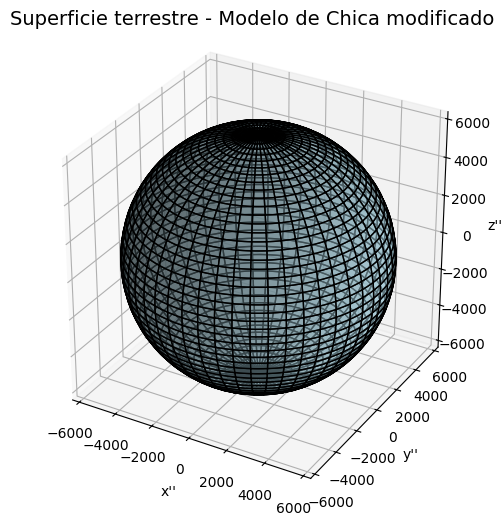

In [40]:
# Arreglo con los valores de "phi_prime" desde polo sur a polo norte.
phi_prime_n = np.linspace(-np.pi/2, np.pi/2, 2000)

# Función para relacionar latitudes geográficas y geocéntricas.
def lat_f(phi, phi_prime):
    return phi - c1_n*np.sin(2*phi) + c2_n*np.sin(4*phi) - phi_prime

# Almacenar los valores de "phi".
phi_n = np.zeros(len(phi_prime_n))
for i in range(len(phi_prime_n)):
    phi_n[i] = root(lat_f, x0=phi_prime_n[i], args=(phi_prime_n[i],)).x[0]

# Generar los valores de radio efectivo.
rho_n = a_n*(1 - 2*e_n**2 * np.sin(phi_n)**2 + e_n**4 * np.sin(phi_n)**2) / \
        np.sqrt(1 - e_n**2 * np.sin(phi_n)**2)  # Radio efectivo
# Definir ángulos polares para la revolución completa.
varphi_T = np.linspace(0, 2*np.pi, 200)

# Crear malla 2D para coordenadas.
Phi, Theta = np.meshgrid(phi_prime_n, varphi_T)
Rho, _ = np.meshgrid(rho_n, varphi_T)

# Cambio de coordenadas a x'', y'', z''.
X = Rho * np.cos(Phi) * np.cos(Theta)
Y = Rho * np.cos(Phi) * np.sin(Theta)
Z = Rho * np.sin(Phi)

# Graficación de la Tierra.
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
# Superficie terrestre.
ax.plot_surface(X, Y, Z, color='lightblue', edgecolor='k', alpha=0.6, shade=True)

# Etiquetas de ejes.
ax.set_xlabel("x''")
ax.set_ylabel("y''")
ax.set_zlabel("z''")

# Límites simétricos, para ver la esfera completa.
ax.set_xlim(-a_n, a_n)
ax.set_ylim(-a_n, a_n)
ax.set_zlim(-a_n, a_n)
# Título.
ax.set_title("Superficie terrestre - Modelo de Chica modificado", fontsize=14)

# Mantener proporciones reales.
ax.set_box_aspect([1,1,1])

plt.show()

## Movimientos periódicos de la Tierra

Ahora, para simular los movimientos periódicos de la Tierra, aplicamos una estrategia similar a la usara para modelar el movimiento de la Luna: estudiar las matrices de rotación pasiva necesarias para alinear la Base Solar con la Base Terrestre, seguidamente, empleamos sus matrices inversas para establecer la orientación correcta de los puntos de la superficie terrestre dentro del sistema solar.

### a) Nutación

El eje de rotación de la Tierra se encuentra inclinado aproximadamente $23^\circ$ respecto a la normal del plano de la eclíptica, sin embargo, este ángulo no es constante, presenta oscilaciones periódicas en función del tiempo.

En nuestro sistema, la _nutación_ se puede representar como una oscilación en el ángulo formado entre el eje $\hat{z}$ y el eje $\hat{z}''$, visualmente similar a un sutil "cabeceo" del eje de rotación. Para imponer esta inclinación a la Base Solar, podemos emplear una matriz de rotación respecto al eje $\hat{x}$ o al eje $\hat{y}$; en este caso, seleccionamos la primera opción de manera arbitraria. Considere la matriz de rotación respecto al eje $\hat{x}$, para un ángulo $\varphi_N$ definido como $\varphi_N(t) = 23.439^\circ + 0.00256^\circ\cdot sin(\varphi_{Ni}+2\pi t/T_N)$, con $T_N:$ Periodo de nutación terrestre ($T_N \approx 18.6$ años) está dada por

$$
S_N^{-1}(\varphi_N) =
\begin{pmatrix}
1 & 0 & 0 \\
0 & \cos(\varphi_N) & -\sin(\varphi_N) \\
0 & \sin(\varphi_N) & \cos(\varphi_N)
\end{pmatrix}
$$  

### b) Precesión

La _precesión_ de la Tierra es un movimiento en el que el eje de rotación terrestre describe un cono alrededor de la normal al plano de la eclíptica, manteniendo la inclinación determinada por la nutación. Este movimiento origina un lento desplazamiento de los polos celestes y del equinoccio.

En términos de transformaciones lineales, si nos enfocamos únicamente en  los ejes de la Base Terrestre, notaremos este movimiento es análogo a la precesión nodal de la órbita lunar. En otras palabras, podemos representar la precesión de la Tierra mediante una rotación respecto al eje $\hat{z}$ de la Base Solar.

$$
S_P^{-1}(\varphi_P) =
\begin{pmatrix}
\cos(\varphi_P) & -\sin(\varphi_P) & 0 \\
\sin(\varphi_P) & \cos(\varphi_P) & 0 \\
0 & 0 & 1
\end{pmatrix}
$$

donde el ángulo $\varphi_P$ lo definimos en función del periodo correspondiente tal que $\varphi_P(t) = \varphi_{Pi} + 2\pi t/T_P$, con $T_P$: Periodo de precesión terrestre ($T_P\approx 25772$ años).

### c) Rotación

El movimiento periódico más evidente de la Tierra es la rotación de su superficie alrededor del eje de rotación. En nuestra notación, esto corresponde a una rotación pasiva respecto al eje $\hat{z}''$. Nótese que este vector cambia su orientación con el tiempo, por lo que no es posible emplear directamente las matrices de rotación convencionales. Sea

$$
\hat{z}'' = S_P^{-1}(\varphi_P)\cdot S_N^{-1}(\varphi_N)\cdot \hat{z} = \begin{pmatrix}
\sin(\varphi_P) \, \sin(\varphi_N) \\
- \cos(\varphi_P) \, \sin(\varphi_N) \\
\cos(\varphi_N)
\end{pmatrix}
$$

podemos usar nuevamente la fórmula de rotación de Rodrigues para generar la matriz de rotación respecto al eje $\hat{z}''$, para un ángulo $\varphi_R$ definido como $\varphi_R(t)=\varphi_{Ri} + 2\pi t/T_R$.

$$
S_R^{-1}(\varphi_R) = \cos(\varphi_R)\cdot
\begin{pmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{pmatrix}
+ [1-\cos(\varphi_R)]\cdot
\begin{pmatrix}
(z''_{x})^2 & z''_{x} z''_{y} & z''_{x} z''_{z} \\
z''_{y} z''_{x} & (z''_{y})^2 & z''_{y} z''_{z} \\
z''_{z} z''_{x} & z''_{z} z''_{y} & (z''_{z})^2
\end{pmatrix} + \sin(\varphi_R)\cdot \begin{pmatrix}
0 & -z''_z & z''_y \\
z''_z & 0 & -z''_x \\
-z''_y & z''_x & 0
\end{pmatrix}
$$

## d) Expresión resultante

Con todo lo anterior, podemos obtener las coordenadas de un punto de la superficie terrestre generado a través del Modelo de Chica modificado, en términos de la Base Solar y medido respecto al origen, considerando las matrices de rotación inversas.

$$
\vec{r}(\varphi_N, \varphi_P, \varphi_R) = S_N(\varphi_N)\cdot S_P(\varphi_P)\cdot S_R(\varphi_R) \cdot \vec{r}''
$$

O de manera equivalente, dado que definimos todos los ángulos en función del tiempo común $t$, podemos escribir

$$
\vec{r}(t) = S_N\big[\varphi_N(t)\big]\cdot S_P\big[\varphi_P(t)\big]\cdot S_R\big[\varphi_R(t)\big] \cdot \vec{r}(t)''
$$

In [41]:
# Generación de símbolos necesarios para el movimiento de la Tierra.
a, b, c, e, rho = smp.symbols('a, b, c, e, rho') # Parámetros del Modelo de Chica
varphi_R, varphi_P, varphi_N = smp.symbols(r'\varphi_R, \varphi_P, \varphi_N') # Ángulos de rotación

In [42]:
# Matriz de nutación.
S_N_inv = smp.Matrix([[1, 0, 0], [0, smp.cos(varphi_N), -smp.sin(varphi_N)], [0, smp.sin(varphi_N), smp.cos(varphi_N)]])

S_N_inv

Matrix([
[1,              0,               0],
[0, cos(\varphi_N), -sin(\varphi_N)],
[0, sin(\varphi_N),  cos(\varphi_N)]])

In [43]:
# Matriz de precesión.
S_P_inv = smp.Matrix([[smp.cos(varphi_P), -smp.sin(varphi_P), 0], [smp.sin(varphi_P), smp.cos(varphi_P), 0], [0, 0, 1]])

S_P_inv

Matrix([
[cos(\varphi_P), -sin(\varphi_P), 0],
[sin(\varphi_P),  cos(\varphi_P), 0],
[             0,               0, 1]])

In [44]:
# Matriz de rotación terrestre.
z_BT = S_P_inv*S_N_inv*smp.Matrix([0, 0, 1])
S_R_inv = smp.cos(varphi_R)*smp.eye(3) + (1-smp.cos(varphi_R))*(z_BT*z_BT.T) + smp.sin(varphi_R)*smp.Matrix([[0, -z_BT[2], z_BT[1]], [z_BT[2], 0, -z_BT[0]], [-z_BT[1], z_BT[0], 0]])

# Visualización.
S_R_inv

Matrix([
[                                       (1 - cos(\varphi_R))*sin(\varphi_N)**2*sin(\varphi_P)**2 + cos(\varphi_R),             -(1 - cos(\varphi_R))*sin(\varphi_N)**2*sin(\varphi_P)*cos(\varphi_P) - sin(\varphi_R)*cos(\varphi_N),  (1 - cos(\varphi_R))*sin(\varphi_N)*sin(\varphi_P)*cos(\varphi_N) - sin(\varphi_N)*sin(\varphi_R)*cos(\varphi_P)],
[           -(1 - cos(\varphi_R))*sin(\varphi_N)**2*sin(\varphi_P)*cos(\varphi_P) + sin(\varphi_R)*cos(\varphi_N),                                         (1 - cos(\varphi_R))*sin(\varphi_N)**2*cos(\varphi_P)**2 + cos(\varphi_R), -(1 - cos(\varphi_R))*sin(\varphi_N)*cos(\varphi_N)*cos(\varphi_P) - sin(\varphi_N)*sin(\varphi_P)*sin(\varphi_R)],
[(1 - cos(\varphi_R))*sin(\varphi_N)*sin(\varphi_P)*cos(\varphi_N) + sin(\varphi_N)*sin(\varphi_R)*cos(\varphi_P), -(1 - cos(\varphi_R))*sin(\varphi_N)*cos(\varphi_N)*cos(\varphi_P) + sin(\varphi_N)*sin(\varphi_P)*sin(\varphi_R),                                                           (1 - cos(\v

In [49]:
# Invertir las matrices de rotación.
S_N = S_N_inv.inv()
S_P = S_P_inv.inv()
S_R = S_R_inv.inv()

In [70]:
S_N

Matrix([
[1,                                                    0,              0],
[0, -sin(\varphi_N)**2/cos(\varphi_N) + 1/cos(\varphi_N), sin(\varphi_N)],
[0,                                      -sin(\varphi_N), cos(\varphi_N)]])

In [72]:
S_P

Matrix([
[-sin(\varphi_P)**2/cos(\varphi_P) + 1/cos(\varphi_P), sin(\varphi_P), 0],
[                                     -sin(\varphi_P), cos(\varphi_P), 0],
[                                                   0,              0, 1]])

In [73]:
S_R

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                             (-sin(\varphi_N)**2*sin(\varphi_P)**2*sin(\varphi_R)**2 + sin(\varphi_N)**2*cos(\varphi_P)**2*cos(\varphi_R)**2 - sin(\varphi_N)**2*cos(\varphi_P)**2*cos(\varphi_R) + cos(\varphi_N)**2*cos(\varphi_R)**2 - cos(\varphi_N)**2*cos(\varphi_R) - cos(\varphi_R)**2)/(sin(\varphi_N)**4*sin(\varphi_P)**4*sin(\varphi_R)**2*cos(\varphi_R) - sin(\varphi_N)**4*sin(\varphi_P)**4*sin(\varphi_R)**2 + 2*sin(\varphi_N)**4*sin(\varphi_P)**2*sin(\varphi_R)**2*cos(\varphi_P)**2*cos(\varphi_R) - 2*sin(\varphi_N)**4*sin(\varphi_P)**2*sin(\varphi_R)**2*cos(\varphi_P)**2 + sin(\varphi_N)**4*sin(\

# Sombra de la Luna

Los eclipses solares se clasifican en tres tipos:

- **Totales**: Ocurren cuando el diámetro angular de la Luna (su tamaño aparente en el cielo) es mayor que el del Sol. En este caso, el satélite logra cubrir por completo el disco solar. Se producen cuando el cono de *umbra* de la Luna alcanza la superficie terrestre.

- **Anulares**: Se producen cuando el diámetro angular de la Luna es menor que el del Sol. El satélite no logra ocultar el disco solar en su totalidad, dejando visible un característico “anillo de fuego” alrededor de la Luna. Se producen cuando el cono de *antumbra* de la Luna incide sobre la superficie terrestre.

- **Parciales**: Tienen lugar cuando la Luna solo cubre una parte del Sol. En estas circunstancias, el eclipse no llega a ser total ni anular, lo que se observa es una fracción del disco solar oculto. Se producen en las regiones alcanzadas únicamente por la *penumbra* de la Luna.